In [16]:
from astropy import units as u
from astropy.coordinates import SkyCoord
from photutils import CircularAperture
from photutils import CircularAnnulus
from astropy.io import fits
from astropy import units as u
import numpy as np
from astropy.nddata import CCDData
import ccdproc
import glob
import matplotlib
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval
from astropy.visualization import *
from astropy.visualization.mpl_normalize import ImageNormalize
import math

In [17]:
ten_stars = [[198, 404],[199, 736],[263,892],[374, 517],[224,324],[75, 211],[935,357],[530,374],[303,619],[63, 600],[213,988]]

In [18]:
ten_apertures = CircularAperture(ten_stars, 16)

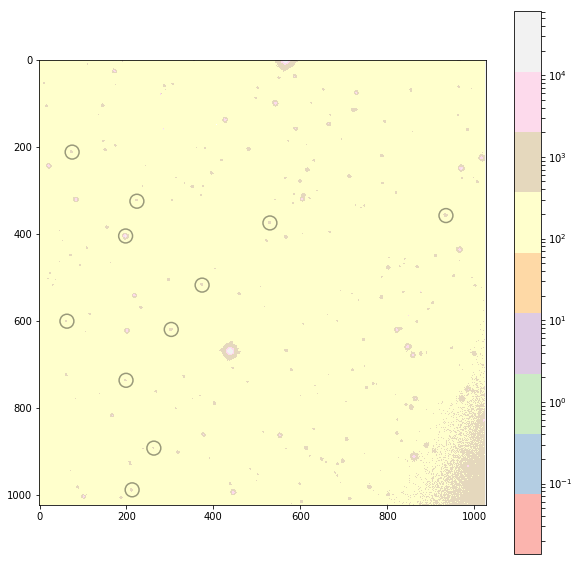

In [19]:
img = fits.open("quadRU.fits")
img_d = img[0].data
norm = ImageNormalize(stretch=SquaredStretch())
from matplotlib.colors import LogNorm
fig, ax = plt.subplots(1,1)
fig.set_size_inches(10,10)
plt.imshow(img_d, cmap="Pastel1", norm=LogNorm())
plt.colorbar()
ten_apertures.plot(color="black", lw=1.5, alpha=0.4)

In [20]:
from photutils import aperture_photometry
the_table_center = aperture_photometry(img_d, ten_apertures, method="center")
the_table_exact = aperture_photometry(img_d, ten_apertures, method="exact")
the_table_subpixel = aperture_photometry(img_d, ten_apertures, method="subpixel")
print(the_table_center)
print(the_table_exact)
print(the_table_subpixel)

 id xcenter ycenter    aperture_sum   
      pix     pix                     
--- ------- ------- ------------------
  1   198.0   404.0  650367.7444834658
  2   199.0   736.0  211999.8025504723
  3   263.0   892.0  206071.4256182895
  4   374.0   517.0 224740.87077447434
  5   224.0   324.0    219504.32201424
  6    75.0   211.0  214879.2746677135
  7   935.0   357.0  255565.0281343165
  8   530.0   374.0  238696.4248305512
  9   303.0   619.0 236358.81033821328
 10    63.0   600.0 213727.56784977714
 11   213.0   988.0 214006.69226857735
 id xcenter ycenter    aperture_sum   
      pix     pix                     
--- ------- ------- ------------------
  1   198.0   404.0  653316.4725134778
  2   199.0   736.0 214726.40787704173
  3   263.0   892.0 208871.49790316875
  4   374.0   517.0 227684.14102514973
  5   224.0   324.0 222418.84991175373
  6    75.0   211.0 217753.63034822914
  7   935.0   357.0 258822.18943236567
  8   530.0   374.0 241675.77429227225
  9   303.0   619.0 23925

In [21]:
ten_annuli = CircularAnnulus(ten_stars, 10, 16)

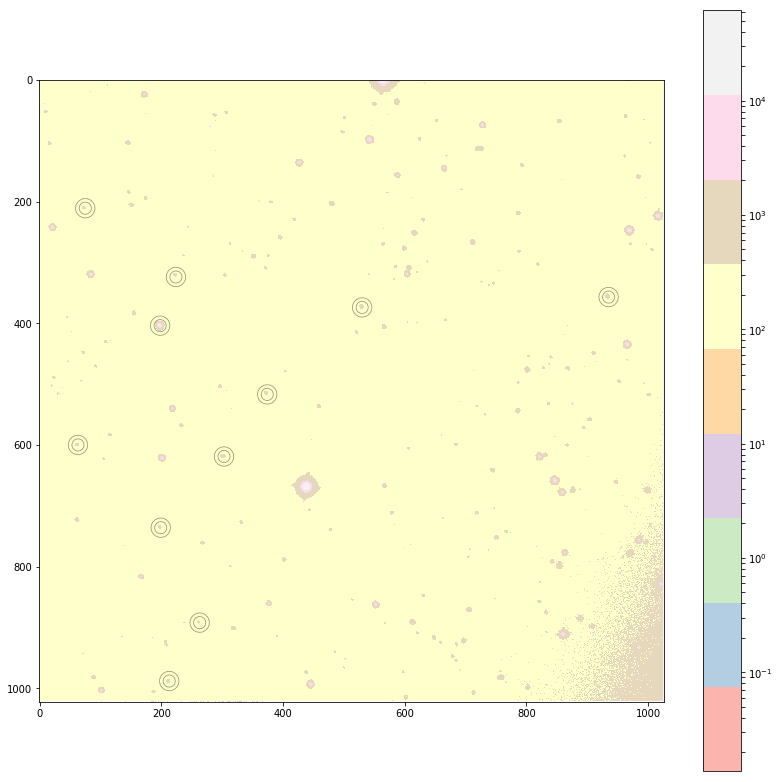

In [22]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(14,14)
plt.imshow(img_d, cmap="Pastel1", norm=LogNorm())
plt.colorbar()
ten_annuli.plot(color="black", lw=.8, alpha=0.4)

In [23]:
#ten_apertures = CircularAperture(ten_stars, 16)
# nts: divide aperture_sum by the area within the aperture
#ten_annuli = CircularAnnulus(ten_stars, 10, 16)
#the_table_center = aperture_photometry(img_d, ten_annuli, method="center")
#print(the_table_center['aperture_sum'])
plotter = [] #x circular ap sum, y annul ap sum, z i, a j, b k
ww = []
qq = []
ee = []
rr = []
tt = []
yy = []
ww2 = []
ww3 = []
maxrad = 20
# the maximum radius to use
for i in range(2,maxrad):
    circ = CircularAperture(ten_stars[0], i)
    x = aperture_photometry(img_d, circ, method="center")['aperture_sum'][0]
    qq.append(x/(math.pi*(i**2)))
    yy.append(i)
for j in range(2,maxrad):
        #for k in [3, 8, 10, 15, 20]:#range(j+1,23):
    annul = CircularAnnulus(ten_stars[0], j, j+6)
    annul2 = CircularAnnulus(ten_stars[0], j, j+3)
    annul3 = CircularAnnulus(ten_stars[0], j, j+12)
    y = aperture_photometry(img_d, annul, method="center")['aperture_sum'][0]
    y2 = aperture_photometry(img_d, annul2, method="center")['aperture_sum'][0]
    y3 = aperture_photometry(img_d, annul3, method="center")['aperture_sum'][0]
    #z = i
    a = j
    b = 6
            #plotter.append([z, a, b, x, y])
    ww.append(y/ ((math.pi*((j+6)**2)) - (math.pi*(j**2))) )
    ww2.append(y2/ ((math.pi*((j+3)**2)) - (math.pi*(j**2))))
    ww3.append(y3/ ((math.pi*((j+12)**2)) - (math.pi*(j**2))))
    #ee.append(z)
    rr.append(a)
    tt.append(b)
#plt.plot_surface(plotter)
#print(plotter)


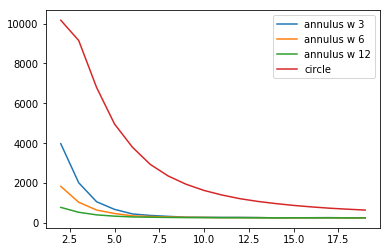

In [24]:
plt.plot(rr, ww2)
plt.plot(rr, ww)
plt.plot(rr, ww3)
plt.plot(yy, qq)
plt.legend(["annulus w 3", "annulus w 6", "annulus w 12", "circle"], loc='upper right')
qq.append(x)
# x-axis = inner radii for annulus, radii for circular, w=diff between inner and outer radii in annulus
# value of plots decrease from the value of the star down to the average value of the whole sky, which tends to be noise
# difference between red and [whatever color] is the subtracted value

In [25]:
from photutils.psf import IterativelySubtractedPSFPhotometry
from astropy.table import Table
from photutils.datasets import (make_random_gaussians_table, make_noise_image, make_gaussian_sources_image)
from photutils.psf import (IterativelySubtractedPSFPhotometry,
                           BasicPSFPhotometry)
from photutils import MMMBackground
from photutils.psf import IntegratedGaussianPRF, DAOGroup
from photutils.detection import DAOStarFinder
from photutils.detection import IRAFStarFinder
from astropy.table import Table
from astropy.modeling.fitting import LevMarLSQFitter

In [26]:
sigma_psf = 2.0
psf_model = IntegratedGaussianPRF(sigma=sigma_psf)
psf_model.x_0.fixed = True
psf_model.y_0.fixed = True
image = fits.getdata("quadRU.fits")
daogroup = DAOGroup(crit_separation=8)
mmm_bkg = MMMBackground()
iraffind = IRAFStarFinder(threshold=2.5*mmm_bkg(image), fwhm=4.5)
fitter = LevMarLSQFitter()
gaussian_prf = IntegratedGaussianPRF(sigma=2.05)
gaussian_prf.sigma.fixed = False
itr_phot_obj = IterativelySubtractedPSFPhotometry(finder=iraffind,
group_maker=daogroup,bkg_estimator=mmm_bkg,psf_model=psf_model,fitter=fitter,fitshape=(11, 11),niters=2)
phot_results = itr_phot_obj(image)
basic = BasicPSFPhotometry(finder=iraffind,
group_maker=daogroup,bkg_estimator=mmm_bkg,psf_model=psf_model,fitter=fitter,fitshape=(11, 11))
b_img = basic(image)

In [36]:
np.set_printoptions(threshold=np.nan)


In [47]:
ten_stars = [[198, 404],[199, 736],[263,892],[374, 517],[224,324],[75, 211],[935,357],[530,374],[303,619],[63, 600],[213,988]]
b_img2 = []
for x in range(0, len(b_img)):
    newRow = []
    for y in range(0, len(b_img[x])):
        newRow.append(int(b_img[x][y]))
    b_img2.append(newRow)
np.savetxt("b_img.txt", b_img2) #delimiter=",")
# their flux is just the aperture sum column
# ids: 

In [28]:
BasicPSFPhotometry

photutils.psf.photometry.BasicPSFPhotometry

In [29]:
xxx = 340.88
yyy = 1019.79
print(aperture_photometry(img_d, CircularAperture([xxx, yyy], 5), method="center")['aperture_sum'])
print(CircularAperture([xxx, yyy], 5).area())
print(aperture_photometry(img_d, CircularAperture([xxx, yyy], 5), method="center")['aperture_sum']/CircularAperture([xxx, yyy], 5).area())

   aperture_sum  
-----------------
604.6526181891609
78.53981633974483
   aperture_sum   
------------------
7.6986762430609135


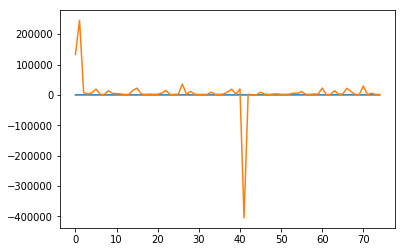

In [31]:
points = []
for i in range(75):
    points.append([i, b_img[i]['flux_fit']-b_img[i]['flux_0']]) # flux_0 is the aperture output but you can use the manual aperture output
    
plt.plot(points)
# TODO: only do this for the stars you were looking at before
# note: this plot is for all the stars that were detected, not necessarilly actual stars
54, 55 47 52 39 37 33 26 23 9 

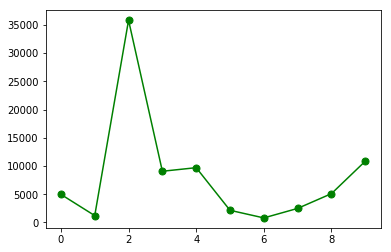

In [56]:
points = []
points2 = []
using = [9, 23, 26, 33, 37, 39, 47, 52, 54, 55] # these are the indices of real stars, no risk of just random space
for i in using:
    points.append([i, b_img[i]['flux_fit']-b_img[i]['flux_0']]) # flux_0 is the aperture output but you can use the manual aperture output
    points2.append(b_img[i]['flux_fit']-b_img[i]['flux_0']) # flux_0 is the aperture output but you can use the manual aperture output
    
plt.plot(points2, "-g.", markersize=14)
#print(points)